In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))
sys.path.append(str(Path.cwd().parent / 'label_anything' / 'data'))

In [2]:
from data.dataset import LabelAnythingDataset, VariableBatchSampler
from transforms import CustomResize, CustomNormalize
from accelerate import Accelerator

import wandb
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from torchvision.transforms import Compose, ToTensor, Resize, PILToTensor
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader
from safetensors.torch import load_file
import timeit
from PIL import Image
import numpy as np
import cv2
import os

import lovely_tensors as lt
lt.monkey_patch()

from label_anything.models import build_lam_no_vit
from label_anything.experiment.substitution import Substitutor

/home/pasquale/projects/LabelAnything/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Helper functions

In [3]:
def get_image(image_tensor):
    MEAN = np.array([123.675, 116.280, 103.530]) / 255
    STD = np.array([58.395, 57.120, 57.375]) / 255
    unnormalized_image = (image_tensor.cpu().numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return Image.fromarray(unnormalized_image)

In [4]:
def draw_points(img: Image, points: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(points):
        for point in cat:
            x, y = point
            x, y = int(x), int(y)
            img = cv2.circle(img, (x, y), 5, colors[i], -1)
    return img

In [5]:
def draw_masks(img: Image, masks: torch.Tensor, colors):
    # here masks is a dict having category names as keys
    # associated to a list of binary masks
    masked_image = resize(img.copy(), 256)
    
    for i, mask in enumerate(masks):
        mask = mask.cpu().numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resize(img, 256)), 0.3, masked_image, 0.7, 0)

In [32]:
def draw_seg(img: Image, seg: torch.Tensor, colors, num_classes):
    resized_image = resize(img.copy(), seg.shape[-2:])
    masked_image = resized_image.copy()
    for i in range(num_classes):
        binary_mask = (seg == i)[0]
        mask = binary_mask.cpu().numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resized_image), 0.3, masked_image, 0.7, 0)

In [7]:
def draw_boxes(img: Image, boxes: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(boxes):
        for box in cat:
            x1, y1, x2, y2 = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[i], 2)
    return img

In [8]:
def draw_all(img: Image, masks, boxes, points, colors):
    segmented_image = draw_masks(img, masks, colors)
    img = Image.fromarray(segmented_image)
    img = resize(img, 1024)
    img = draw_boxes(img, boxes, colors)
    img = Image.fromarray(img)
    img = draw_points(img, points, colors)
    img = Image.fromarray(img)
    return img

In [9]:
def plot_all(dataset, batch, colors):
    unbatched = {k : v[0] for k, v in batch.items()}
    images = [
    draw_all(
        get_image(unbatched["images"][i]),
        unbatched["prompt_masks"][i],
        unbatched["prompt_bboxes"][i],
        unbatched["prompt_points"][i],
        colors
    )
    for i in range(unbatched["images"].shape[0])
]
    
    num_images = len(images)
    cols = 2
    rows = (num_images + 1) // cols

    fig, ax = plt.subplots(rows, cols, figsize=(20, 20))

    for i, img in enumerate(images):
        cats = [dataset.categories["coco"][cat]["name"] for cat in unbatched["classes"][i]]
        if rows == 1:
            ax[i % cols].imshow(img)
            ax[i % cols].set_title(", ".join(cats))
            ax[i % cols].axis("off")
        else:
            ax[i // cols, i % cols].imshow(img)
            ax[i // cols, i % cols].set_title(", ".join(cats))
            ax[i // cols, i % cols].axis("off")
        
    plt.show()

In [10]:
def resize_ground_truth(ground_truth, dims):
    return ground_truth[:dims[0], :dims[1]]

In [11]:
def load_checkpoint(accelerator, run_id):
    api = wandb.Api()
    run = api.run(f"cilabuniba/LabelAnything/{run_id}")
    files = run.files()
    model_file = None
    for file in files:
        if "model" in file.name and "best" in file.name:
            model_file = file.download(replace=True)
    accelerator.load_state("best")

In [22]:
def get_embeddings_names(batch):
    image_ids = batch['image_ids']
    z_filled = [[str(image_id).zfill(12) for image_id in item] for item in image_ids]
    flattened = [item for sublist in z_filled for item in sublist]
    # filter embeddings already present in EMBEDDINGS_DIR
    filtered = [item for item in flattened if not Path(f"{EMBEDDINGS_DIR}/{item}.safetensors").exists()]
    print(" ".join(filtered))
    
def set_embeddings(accelerator, batch):
    item = batch['image_ids'][0]
    safetensors = []
    for id in item:
        safetensors.append(load_file(f"{EMBEDDINGS_DIR}/{str(id).zfill(12)}.safetensors")['embedding'])
        
    safetensors = torch.stack(safetensors).unsqueeze(0)
    safetensors = safetensors.to(accelerator.device)
    batch['embeddings'] = safetensors
    return batch

In [13]:
colors = [
    # yellow
    (255, 255, 0),
    # red
    (255, 0, 0),
    # green
    (0, 255, 0),
    # blue
    (0, 0, 255),
    # purple
    (255, 0, 255),
    # cyan
    (0, 255, 255),
    # orange
    (255, 165, 0),
    # pink
    (255, 192, 203),
    # brown
    (139, 69, 19),
    # grey
    (128, 128, 128),
    # black
    (0, 0, 0)
]

In [14]:
pdir = Path.cwd().parent

Dataset definition

In [15]:
IMG_DIR = "/ext/stalla/LabelAnything/images/train2017"
ANNOTATIONS_DIR = os.path.join(pdir, "data/annotations/instances_val2017.json")
EMBEDDINGS_DIR = "/ext/stalla/LabelAnything/embeddings"


In [16]:
preprocess = Compose([
    CustomResize(1024),
    PILToTensor(),
    CustomNormalize()
])

In [17]:
dataset = LabelAnythingDataset(
    {
        "coco": {
            "name": "coco",
            "instances_path": ANNOTATIONS_DIR,
            "img_dir": IMG_DIR,
            "preprocess": preprocess,
        }
    }, {}
)
accelerator = Accelerator()
sampler = VariableBatchSampler(
        dataset,
        possible_batch_example_nums=[[1, 8], [1, 4], [1, 2], [1, 1]],
        num_processes=1,
        shuffle=False,
)
dataloader = DataLoader(
        dataset=dataset, batch_sampler=sampler, collate_fn=dataset.collate_fn
)
dataloader = accelerator.prepare(dataloader)
iter_data = iter(dataloader)

Loading dataset annotations from /home/pasquale/projects/LabelAnything/data/annotations/instances_val2017.json...


---
Load model

In [18]:
model = build_lam_no_vit(
    spatial_convs=3,
)
model = accelerator.prepare(model)

Load weights

In [19]:
run_id = "gjdpcfya"
load_checkpoint(accelerator, run_id)

[2024-02-06 11:01:47] INFO - logging.py - Loading states from best
[2024-02-06 11:01:47] INFO - logging.py - All model weights loaded successfully
[2024-02-06 11:01:47] INFO - logging.py - All optimizer states loaded successfully
[2024-02-06 11:01:47] INFO - logging.py - All scheduler states loaded successfully
[2024-02-06 11:01:47] INFO - logging.py - All dataloader sampler states loaded successfully
[2024-02-06 11:01:47] INFO - logging.py - Could not load random states
[2024-02-06 11:01:47] INFO - logging.py - Loading in 0 custom states


In [33]:
(batch, gt), _ = next(iter_data)

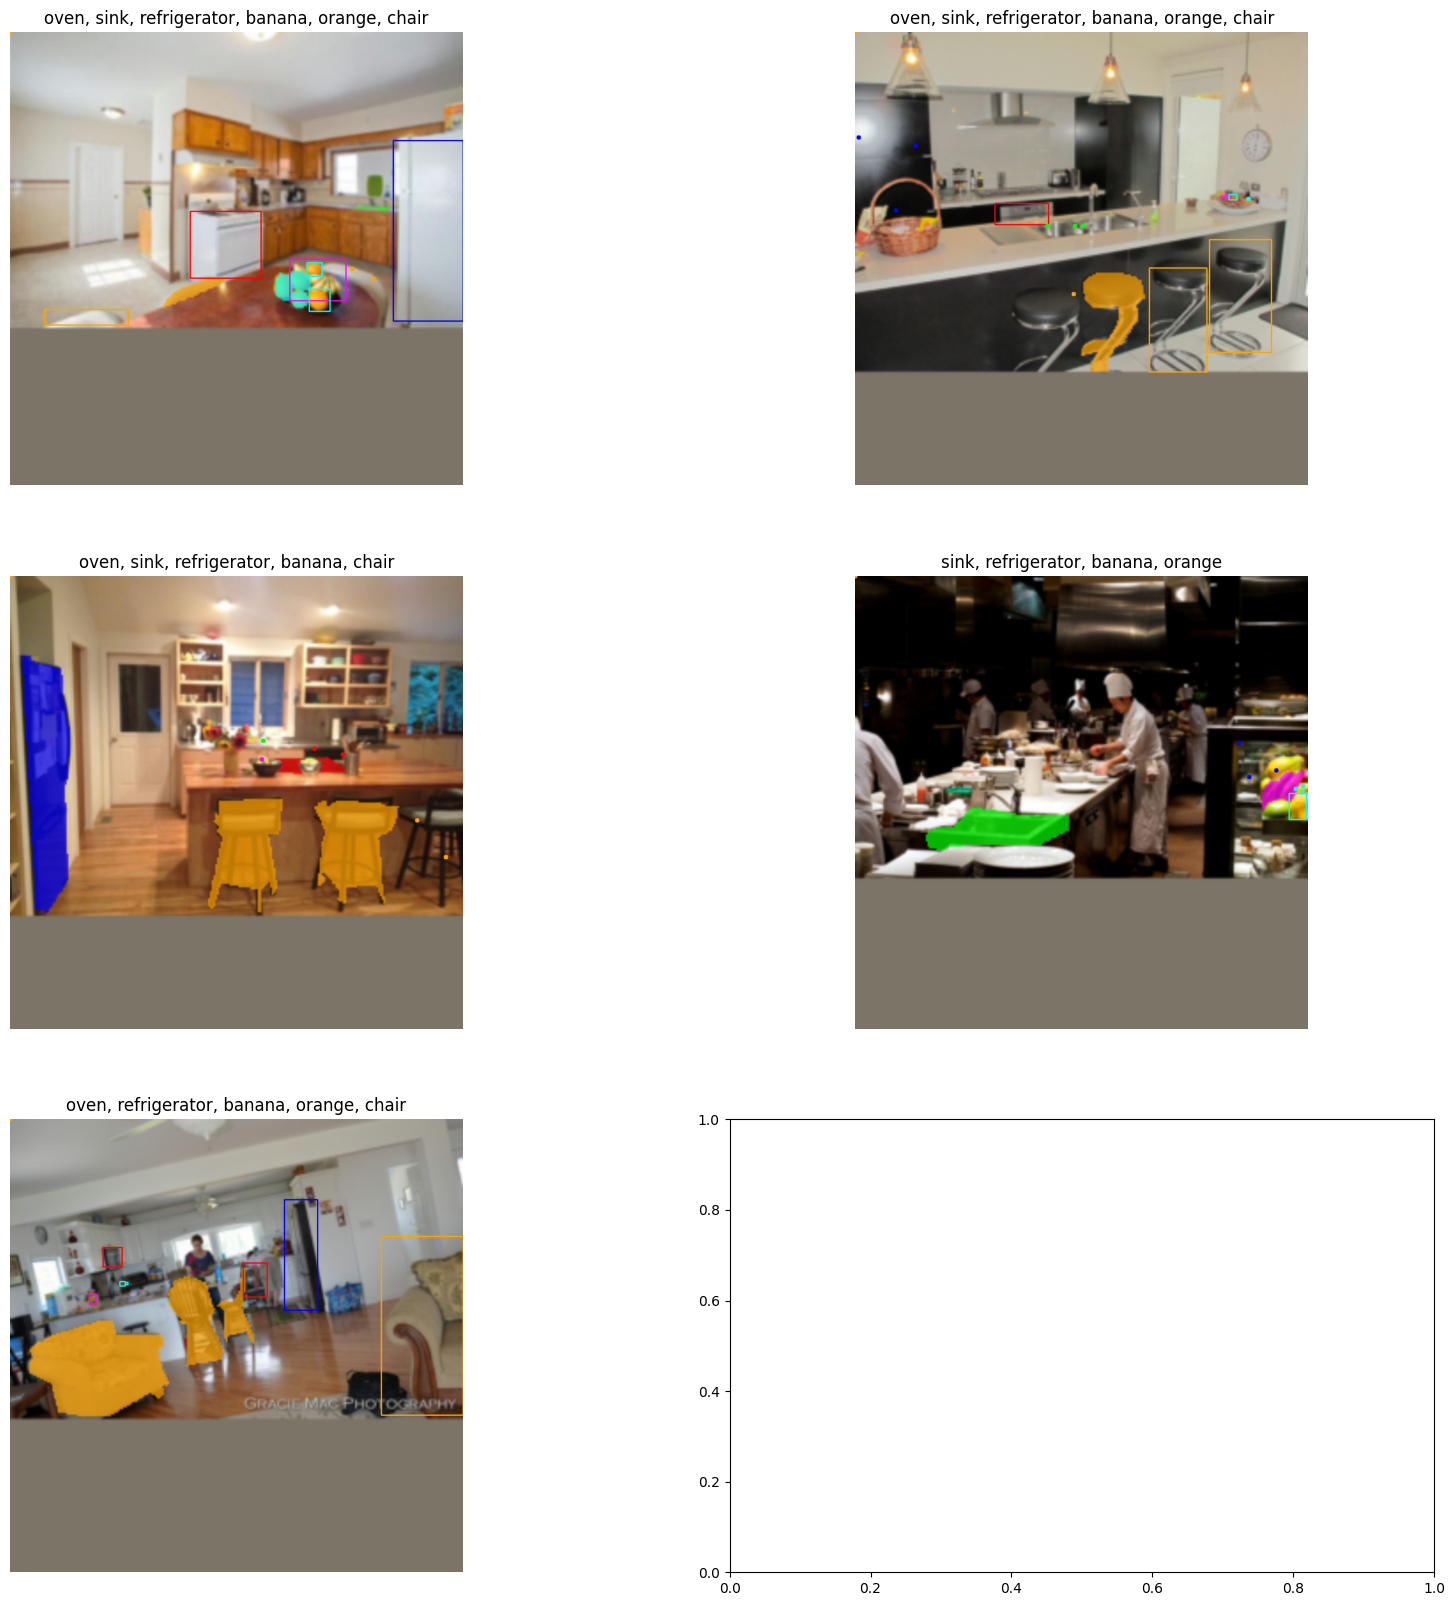

In [34]:
plot_all(dataset, batch, colors)

In [35]:
get_embeddings_names(batch)


000000066231


In [24]:
batch = set_embeddings(accelerator, batch)

 Load the substitutor

In [25]:
substitutor = Substitutor(substitute=False)
substitutor.reset((batch, gt))
input, one_gt = next(iter(substitutor))

In [26]:
seg = model(input)

In [27]:
logits = seg['logits']
examples_class_embeddings = seg['class_examples_embeddings']
class_embeddings = examples_class_embeddings.mean(dim=1)

seg = logits.argmax(dim=1)

In [31]:
img = get_image(input['images'][0, 0])
num_classes = len(input['classes'][0][0])
print(num_classes)

2


In [29]:
segmask = draw_seg(
    get_image(input['images'][0, 0]),
    seg.cpu(),
    colors,
    num_classes=num_classes
)

gtmask = draw_seg(
    get_image(input['images'][0, 0]),
    one_gt,
    colors,
    num_classes=num_classes
)

(640, 640)
(640, 640)
(640, 640)
(640, 640)


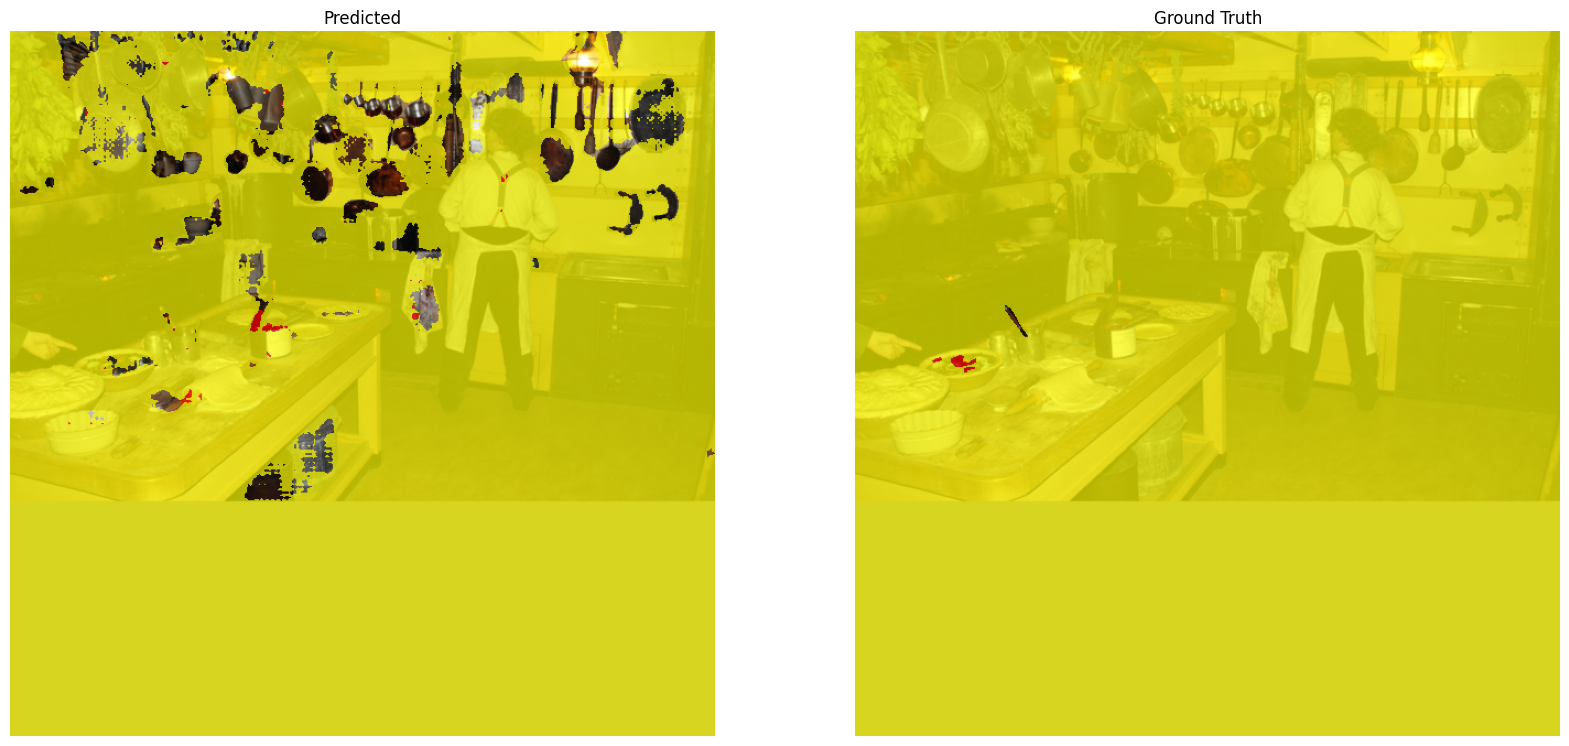

In [30]:
plots = [segmask, gtmask]
titles = ["Predicted", "Ground Truth"]

subplots = plt.subplots(1, 2, figsize=(20, 20))
for i, plot in enumerate(plots):
    subplots[1][i].imshow(plot)
    subplots[1][i].set_title(titles[i])
    subplots[1][i].axis("off")